# Mining Time Series: Dimensionality reduction

## Background

The generic data mining algorithm:

1. Create an _approximation_ of the data, which will fit in main memory, yet retains the essential features of interest.
2. Approximately solve the problem at hand in main memory.
3. Make (hopefully very few) accesses to the original data on disk to confirm the solution obtained in Step 2, or to modify the solution so it agrees with the solution we would have obtained on the original data.

This only works if the approximation allows **lower bounding**. Lower bounding means that for all $Q$ and $S$, we have $D_{LB}(Q',S') \leq D(Q,S)$.

<img src="./images/lower_bounding.png" width="500" />

In [1]:
# Load required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Execute local script with some custom settings
%run -i settings.py  

# Load the data
df = pd.read_csv('data/london-2018.csv', 
                 index_col=0, parse_dates=True)
df

drybulb  relhum  glohorrad  rainfall  windspd  winddir
2018-01-01 01:00:00     6.28   90.50        0.0  0.122079    10.25   266.82
2018-01-01 02:00:00     5.79   88.63        0.0  0.013495    10.55   271.34
2018-01-01 03:00:00     5.10   89.76        0.0  0.000444     8.96   260.11
2018-01-01 04:00:00     4.79   91.80        0.0  0.000199     8.02   242.19
2018-01-01 05:00:00     4.84   92.40        0.0  0.000625     7.74   228.02
...                      ...     ...        ...       ...      ...      ...
2018-12-31 20:00:00     7.26   91.93        0.0  0.015533     3.80   276.39
2018-12-31 21:00:00     7.17   92.34        0.0  0.011580     3.78   277.80
2018-12-31 22:00:00     7.06   92.71        0.0  0.009077     3.85   278.38
2018-12-31 23:00:00     6.71   93.86        0.0  0.012057     3.84   279.12
2019-01-01 00:00:00     6.71   93.03        0.0  0.019290     4.32   282.21

[8760 rows x 6 columns]

## Fourier

In [2]:
def demo_fourier(y):
    """Demonstrate fourier approximation.    
    
    References
    ----------
    @Agustín
    https://dsp.stackexchange.com/questions/40780/how-to-get-the-fourier-series-using-pythons-tt-fft
    
    """
    n = len(y)
    x = np.arange(n)
        
    components = [5, 15, n]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=len(components))
    for ind, c in enumerate(components):
        colors = np.linspace(start=100, stop=255, num=c)
        for i in range(c):
            Y = np.fft.fft(y)
            np.put(Y, range(i+1, n), 0.0)
            ifft = np.fft.ifft(Y)
            color = plt.cm.Reds(int(colors[i]))
            y_ = pd.Series(ifft, y.index)
            y_.plot(ax=ax[ind], alpha=.50, color=color)

        ax[ind].set_title(f"First {c} fourier components")
        y.plot(ax=ax[ind], alpha=0.5, label='original')
        
    plt.tight_layout()
    plt.show()

    
demo_fourier(df.loc['2018-01-01':'2018-01-07', 'drybulb'])

C:\Users\Daniel\Miniconda3\envs\tsar\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


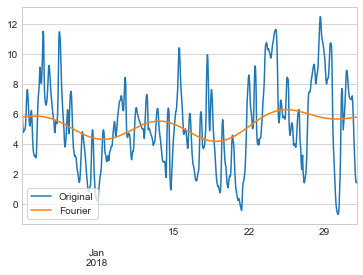

In [3]:
def fourier(y, n_harmonics, plot: bool=True):
    """Compute Fourier transform (optionally plotting)."""
    n = len(y)
    x = np.arange(n)
    
    # Fourier Transform
    Y = np.fft.fft(y)
    idx_0 = range(n_harmonics + 1, n)
    Y[idx_0] = 0
    # Inverse Fourier Transform (sinusoidal)
    ifft = pd.Series(np.fft.ifft(Y), y.index)
    
    if plot:
        fig, ax = plt.subplots()
        y.plot(ax=ax, label='Original')
        ifft.plot(ax=ax, label='Fourier')
        plt.legend(loc='lower left', frameon=True)
        plt.show()        
    
    return Y
    
out = fourier(df.loc['2018-01', 'drybulb'], 3)

## PAA: Piecewise Aggregate Approximation

One of the main proposals in this workshop is to find/create lower bound strings 
(symbolic or discrete approximations). 
A lower bounding symbolic approach allows data miners to:

* Use suffix trees, hashing, markov models etc
* Use text processing and bioinformatic algorithms


**Piecewise Aggregate Approximation** approximates a time series $X$ of length $n$ into vector $\bar{X}=(\bar{x}_1, \ldots,\bar{x}_M)$ of any arbitrary length $M \leq n$ where each of $\bar{x}_i$ is calculated as follows:

$$ \bar{x}_{i} = \frac{M}{n} \sum_{j=n/M(i-1)+1}^{(n/M)i} x_{j} $$

Which simply means that in order to reduce the dimensionality from n to M, we first divide the original time series into $M$ equally sized frames and secondly compute the mean values for each frame. The sequence assembled from the mean values is the PAA approximation (i.e., transform) of the original time series. As it was shown by Keogh et al, the complexity of the PAA transform can be reduced from $O(NM)$ to $O(Mm)$ where $m$ is the number of frames. By using the following distance measure

$$ D_{PAA}(\bar{X},\bar{Y}) \equiv \sqrt{\frac{n}{M}} \sqrt{ \sum_{i=1}^{M} \left( \bar{x}_{i}-\bar{y}_{i} \right) } $$

Yi & Faloutsos, and Keogh et al, have shown that PAA satisfies to the lower bounding condition and guarantees no false dismissals, i.e.:

$$ D_{PAA}(\bar{X},\bar{Y}) \leq D(X,Y) $$

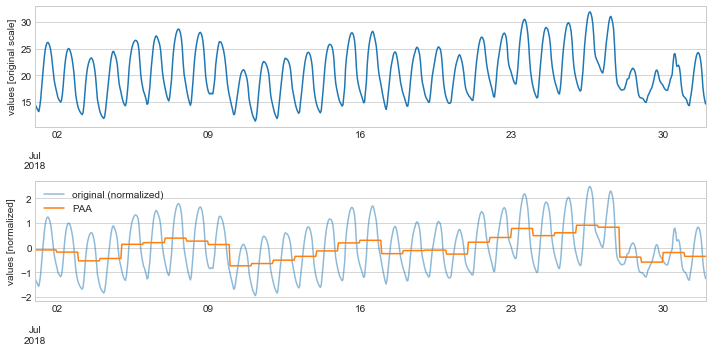

In [4]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance as TSS
from tslearn.piecewise import PiecewiseAggregateApproximation as PAA


def paa(s_raw, n_segments, plot: bool=True):
    # 1 - Normalize (scale)
    s_ref = TSS(mu=0., std=1.).fit_transform(s_raw)
    
    # 2 - Compute PAA
    m_paa = PAA(n_segments=n_segments)
    s_fit = m_paa.fit_transform(s_ref)
    s_paa = m_paa.inverse_transform(s_fit)
    
    # 3 - Export as Time Series
    s_paa = pd.Series(s_paa.squeeze(), s_raw.index)
    s_ref = pd.Series(s_ref.squeeze(), s_raw.index)

    if plot:
        fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 5))
        
        s_raw.plot(ax=ax0)
        ax0.set_ylabel('values [original scale]')
    
        s_ref.plot(ax=ax1, alpha=0.5, label='original (normalized)')
        s_paa.plot(ax=ax1, label='PAA')
        ax1.set_ylabel('values [normalized]')
        ax1.legend()
        
        plt.tight_layout()
        plt.show()
        
    return m_paa, s_paa


_ = paa(df.loc['2018-07', 'drybulb'], n_segments=31)

## SAX: Symbolic Aggregate approXimation

**Symbolic Aggregate ApproXimation** allows: lower bounding of Euclidean distance, dimensionality reduction, and numerosity reduction. SAX firest converts the time series to a PAA representation. Then, convert PAA to symbols. The overall process takes linear time.

<img src="images/SAX1.png" width="350" />

Time series subsequences tend to have a highly Gaussian distribution. Discretization of the PAA representation of a time series into SAX is implemented in a way which produces symbols corresponding to the time series features with equal probability. The extensive and rigorous analysis of various time series datasets available to the original algorithm's authors has shown that the values of _z-normalized_ time series follow the Normal distribution. By using its properties it is easy to pick an equal-sized areas under the Normal curve using lookup tables for the cut lines coordinates, slicing the under-the-Gaussian-curve area.

The $x$ coordinates of these lines are called breakpoints or cuts in the SAX context. The list of breakpoints 
$B=\beta_1,\ldots,\beta_{a-1}$ such that $\beta_{i-1} < \beta_i$ and $\beta_0 = -\infty$, $\beta_a = \infty$ divides the area under $N(0,1)$ into $a$ equal areas. By assigning a corresponding alphabet symbol $\alpha_j$ to each interval $[\beta_{j-1},\beta_j)$, the conversion of the vector of PAA coefficients $\bar{C}$ into the string $\hat{C}$ implemented as follows: 

$$\hat{c}_i = \alpha_j, \; \text{iif}, \; \bar{c}_i \in [ \beta_{j-1}, \beta_{j} )$$

SAX introduces new metrics for measuring distance between strings by extending Euclidean and PAA distances.
The function returning the minimal distance between two string representations of original time series $\hat{Q}$ and $\hat{C}$ is defined as:

$$\text{MINDIST}(\hat{Q},\hat{C}) \equiv \sqrt{\frac{n}{w}} \sqrt{\sum_{i=1}^{w}(\text{dist}(\hat{q}_i,\hat{c}_i))^{2}}$$

where the _dist_ function is implemented by using the lookup table for the particular set of the breakpoints (alphabet size) as shown in the table below,


| <i></i> |    a |    b |    c |    d |
|---------|-----:|-----:|-----:|-----:|
|       a |    0 |    0 | 0.67 | 1.34 |
|       b |    0 |    0 |    0 | 0.67 |
|       c | 0.67 |    0 |    0 |    0 |
|       d | 1.34 | 0.67 |    0 |    0 |


and where the singular value for each cell $(r,c)$ is computed as

$$cell\_{(r,c)} = \begin{cases} 0, \text{if} \left|r-c \right| \leq 1 \\ \beta_{\max(r,c)-1} - \beta_{\min(r,c)-1}, \text{otherwise}\end{cases}$$


SAX distance metrics lower bounds the PAA distance:

$$\sum_{i=1}^{n}(q_{i}-c_{i})^{2} \geq n(\bar{Q}-\bar{C})^{2} \geq n(dist(\hat{Q},\hat{C}))^2$$

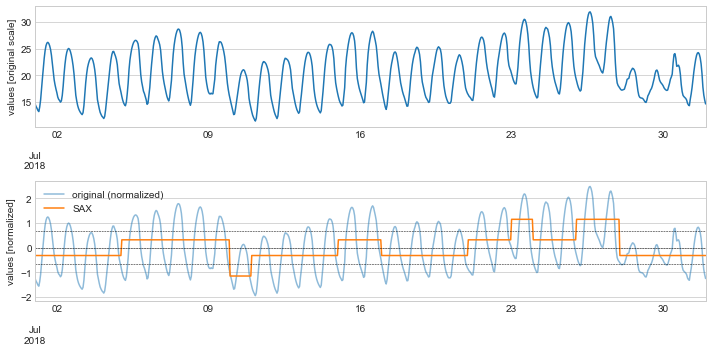

In [5]:
from tslearn.piecewise import SymbolicAggregateApproximation as SAX
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string


def sax(s_raw, n_segments: int, n_alphabet: int, plot: bool=True):
    # 1 - Normalize (scale)
    s_ref = TSS(mu=0., std=1.).fit_transform(s_raw)
    
    # 2 - Compute PAA (optional)
    m_paa = PAA(n_segments=n_segments)
    s_fit = m_paa.fit_transform(s_ref)
    s_paa = m_paa.inverse_transform(s_fit)

    # 3 - Compute SAX
    m_sax = SAX(n_segments=n_segments, alphabet_size_avg=n_alphabet)
    s_fit = m_sax.fit_transform(s_ref)
    s_sax = m_sax.inverse_transform(s_fit)
    
    # 4 - Export as time series
    s_ref = pd.Series(s_ref.squeeze(), s_raw.index)
    s_paa = pd.Series(s_paa.squeeze(), s_raw.index)
    s_sax = pd.Series(s_sax.squeeze(), s_raw.index)
    
    if plot:
        fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 5))
        
        # Plot original data
        s_raw.plot(ax=ax0)
        ax0.set_ylabel('values [original scale]')

        # Plot SAX
        s_ref.plot(ax=ax1, alpha=0.5, label='original (normalized)')
        s_sax.plot(ax=ax1, label='SAX')
        # - add cuts according to alphabet
        cuts = cuts_for_asize(a_size=n_alphabet)
        for ind, v in enumerate(cuts, start=1):
            plt.axhline(y=v, color='black', linestyle='--', linewidth=0.5)
        ax1.set_ylabel('values [normalized]')
        ax1.legend()

        plt.tight_layout()
        plt.show()
    
    a_sax = ts_to_string(s_paa.values, cuts_for_asize(n_alphabet))
    return m_sax, s_sax, a_sax


_ = sax(df.loc['2018-07', 'drybulb'], n_segments=31, n_alphabet=4)

## Activities

## Main References

1. E. Keogh & M. Pazzani. Scaling up dynamic time warping for datamining applications. SIGKDD 2000, pp. 285–289.
1. Lin, J., Keogh, E., Wei, L., & Lonardi, S. (2007). Experiencing SAX: a novel symbolic representation of time series. Data Mining and knowledge discovery, 15(2), 107-144.
1. Herrera, M., Ferreira, A. A., Coley, D., & de Aquino, R. R. (2016). SAX-quantile based multiresolution approach for finding heatwave events in summer temperature time series. AI Communications, 29(6), 725-732.
1. Ferreira, A. A., Barbosa, I. M. R., Aquino, R. R., Herrera, M., Natarajan, S., Fosas, D., & Coley, D. (2018). Adaptive Piecewise and Symbolic Aggregate Approximation as an improved representation method for heat waves detection. In Science and Information Conference (pp. 658-671). Springer, Cham.
1. Senin, P., Lin, J., Wang, X., Oates, T., Gandhi, S., Boedihardjo, A. P., ... & Frankenstein, S. (2018). Grammarviz 3.0: Interactive discovery of variable-length time series patterns. ACM Transactions on Knowledge Discovery from Data (TKDD), 12(1), 10.